In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import holidays
from trading_signals import buy_signal1, buy_signal2, sell_signal1, sell_signal2

In [8]:
def fetch_intraday_data(symbol, date):

    start_datetime = datetime.combine(date, datetime.min.time())
    end_datetime = start_datetime + timedelta(days=1)
    tickerData = yf.Ticker(symbol)
    intraday_data = tickerData.history(start=start_datetime.strftime('%Y-%m-%d'),
                                       end=end_datetime.strftime('%Y-%m-%d'),
                                       interval='1m')  
    if (intraday_data.empty) : return intraday_data
    market_start, market_end = "09:15", "15:30"
    intraday_data = intraday_data.between_time(market_start, market_end)

    return intraday_data #pd dataframe object

In [9]:

# Define the symbol
tickerSymbol = 'JSWENERGY.NS'

# Strategy parameters
initial_capital = 1000000 * 5  # 5x margin
sell_time = datetime.strptime("15:05", "%H:%M").time()  # maximum time to sell

# Costs
brokerage_rate = 20
brokerage_percent = 0.0005
stt_percent = 0.00025
exchange_txn_charge_percent = 0.0000345
sebi_turnover_charge_percent = 0.000001
stamp_duty_percent = 0.00003
start_date = '2024-04-04'
end_date = '2024-05-05'
trades = []

In [10]:
def calculate_costs(order_value, sell=False):
    """
    Calculates the total costs incurred for a trade, including brokerage, 
    exchange transaction charges, STT, SEBI turnover charges, and stamp duty.
    
    :param order_value: The total value of the trade.
    :param sell: Boolean indicating whether the trade is a sell operation. 
                 STT is applied only on sell operations.
    :return: Total cost of the trade.
    """
    brokerage = min(brokerage_rate, brokerage_percent * order_value)
    exchange_txn_charge = exchange_txn_charge_percent * order_value
    sebi_turnover_charge = sebi_turnover_charge_percent * order_value
    stamp_duty = stamp_duty_percent * order_value
    stt_charge = stt_percent * order_value if sell else 0  # STT applied only on sell

    total_cost = brokerage + exchange_txn_charge + sebi_turnover_charge + stamp_duty + stt_charge
    return total_cost

The following code is the simulator for our backtest. This simulator is for intraday strategies only.

In [11]:
trades = []  # Reset trades list
for date in pd.date_range(start_date, end_date, freq='B'):
    # Check if the date is a public holiday in India. This is kinda redundant but meh
    if date in holidays.CountryHoliday('IND', years=date.year).keys():
        continue
    intraday_data = fetch_intraday_data(tickerSymbol, date)
    if intraday_data.empty: continue
    bought = False
    for i in range(15, len(intraday_data)):  # Start from 9.30 AM to have enough data for detection
        prices = intraday_data['Close'].iloc[i-15:i+1]  # Window to use the data
        volumes = intraday_data['Volume'].iloc[0:i+1] 
        #print(volumes)
        current_time = intraday_data.index[i].time()
        if current_time >= sell_time: break
        if (not bought) and (buy_signal1(prices) or buy_signal2(prices)):  #buy_signal1(prices) or buy_signal2(prices)
            # Buy
            entry_price = prices.iloc[-1]
            entry_time = prices.index[-1]
            order_value = initial_capital / entry_price
            purchase_price = prices[-1]
            bought = True
            total_buy_cost = calculate_costs(order_value)  # Assuming this function calculates total costs based on order value

        if (bought and (sell_signal1(prices,purchase_price) or sell_signal2(prices)) ):#or short_rise(prices,purchase_price)
            # Conditions to sell: Stop-loss or opposite condition of buying
                # Sell
                exit_price = prices.iloc[-1]
                exit_time = prices.index[-1]
                gross_profit = (exit_price - entry_price) * order_value
                total_sell_cost = calculate_costs(order_value, sell=True)  # Calculate costs for selling
                net_profit = gross_profit - total_buy_cost - total_sell_cost
                trades.append({'Entry Time': entry_time, 'Entry Price': entry_price, 'Exit Time': exit_time,
                               'Exit Price': exit_price, 'Gross Profit': gross_profit, 'Net Profit': net_profit,
                               'Total Buy Cost': total_buy_cost, 'Total Sell Cost': total_sell_cost})
                bought = False  # Ready to buy again
    if bought:
    # Sell at the end of the day if still holding
        exit_price = intraday_data['Close'][-15]
        exit_time = intraday_data.index[-15]
        gross_profit = (exit_price - entry_price) * order_value
        total_sell_cost = calculate_costs(order_value, sell=True)  # Calculate costs for selling
        net_profit = gross_profit - total_buy_cost - total_sell_cost
        trades.append({'Entry Time': entry_time, 'Entry Price': entry_price, 'Exit Time': exit_time,
                    'Exit Price': exit_price, 'Gross Profit': gross_profit, 'Net Profit': net_profit,
                    'Total Buy Cost': total_buy_cost, 'Total Sell Cost': total_sell_cost})
# Analyze the trades
trades_df = pd.DataFrame(trades)
if not trades_df.empty:
    print(trades_df)
else:
    print("No trades executed.")

JSWENERGY.NS: 1m data not available for startTime=1712169000 and endTime=1712255400. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712255400 and endTime=1712341800. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712514600 and endTime=1712601000. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712601000 and endTime=1712687400. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712687400 and endTime=1712773800. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712773800 and endTime=1712860200. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712860200 and endTime=1712946600. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not availabl

                 Entry Time  Entry Price                 Exit Time   
0 2024-05-03 11:53:00+05:30   629.650024 2024-05-03 12:10:00+05:30  \

   Exit Price  Gross Profit    Net Profit  Total Buy Cost  Total Sell Cost  
0  632.349976  21440.094236  21429.127827         4.49059          6.47582  


In [13]:
# Convert strings to datetime objects for iteration
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d').date()
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d').date()

# Prepare an empty DataFrame for concatenating intraday data
historical_data = pd.DataFrame()

for single_date in pd.date_range(start_date_dt, end_date_dt, freq='B'):  # 'B' frequency is for business days
    print(f"Fetching data for {single_date.date()}")
    intraday_data = fetch_intraday_data(tickerSymbol, single_date.date())
    # Concatenate the intraday data for the current day to the historical_data DataFrame
    historical_data = pd.concat([historical_data, intraday_data])

# The index is set as datetime for plotting and further analysis
historical_data.index = pd.to_datetime(historical_data.index)

print("Completed fetching historical intraday data.")

# Now, historical_data contains all fetched intraday data across the specified date range.


JSWENERGY.NS: 1m data not available for startTime=1712169000 and endTime=1712255400. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712255400 and endTime=1712341800. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712514600 and endTime=1712601000. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712601000 and endTime=1712687400. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712687400 and endTime=1712773800. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712773800 and endTime=1712860200. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not available for startTime=1712860200 and endTime=1712946600. The requested range must be within the last 30 days.
JSWENERGY.NS: 1m data not availabl

Fetching data for 2024-04-04
Fetching data for 2024-04-05
Fetching data for 2024-04-08
Fetching data for 2024-04-09
Fetching data for 2024-04-10
Fetching data for 2024-04-11
Fetching data for 2024-04-12
Fetching data for 2024-04-15
Fetching data for 2024-04-16
Fetching data for 2024-04-17
Fetching data for 2024-04-18
Fetching data for 2024-04-19
Fetching data for 2024-04-22
Fetching data for 2024-04-23
Fetching data for 2024-04-24
Fetching data for 2024-04-25
Fetching data for 2024-04-26
Fetching data for 2024-04-29
Fetching data for 2024-04-30
Fetching data for 2024-05-01


JSWENERGY.NS: No price data found, symbol may be delisted (1m 2024-05-01 -> 2024-05-02)


Fetching data for 2024-05-02
Fetching data for 2024-05-03
Completed fetching historical intraday data.


In [14]:
# Calculate Cumulative and Percent Profits for the trades
trades_df['Cumulative Profit'] = trades_df['Net Profit'].cumsum()
final_cumulative_profit = trades_df['Cumulative Profit'].iloc[-1]
initial_investment = trades_df['Entry Price'].iloc[0] * (initial_capital / trades_df['Entry Price'].iloc[0])
percent_profit_with_margin = (final_cumulative_profit / initial_investment) * 100
percent_profit_without_margin = (final_cumulative_profit / (initial_investment / 5)) * 100  # Assuming 5x margin

# Print Cumulative and Percent Profits
print(f"Final Cumulative Profit: {final_cumulative_profit}")
print(f"Percent Profit with Margin: {percent_profit_with_margin:.2f}%")
print(f"Percent Profit without Margin: {percent_profit_without_margin:.2f}%")

# Simple Buy-at-Start and Sell-at-End Strategy
buy_price = historical_data['Open'].iloc[0]  # The opening price of the start date
sell_price = historical_data['Close'].iloc[-1]  # The closing price of the end date
simple_strategy_profit = (sell_price - buy_price) * (initial_capital / buy_price)
percent_simple_strategy_profit = (simple_strategy_profit / initial_investment) * 100

# Print Profit from Simple Strategy
print(f"Profit from Simple Buy-at-Start and Sell-at-End Strategy: {simple_strategy_profit}")
print(f"Percent Profit from Simple Strategy: {percent_simple_strategy_profit:.2f}%")

Final Cumulative Profit: 21429.127826892614
Percent Profit with Margin: 0.43%
Percent Profit without Margin: 2.14%
Profit from Simple Buy-at-Start and Sell-at-End Strategy: -59615.38461538462
Percent Profit from Simple Strategy: -1.19%


Now, we plot the data to visualise whether we can do better by tweaking our functions.

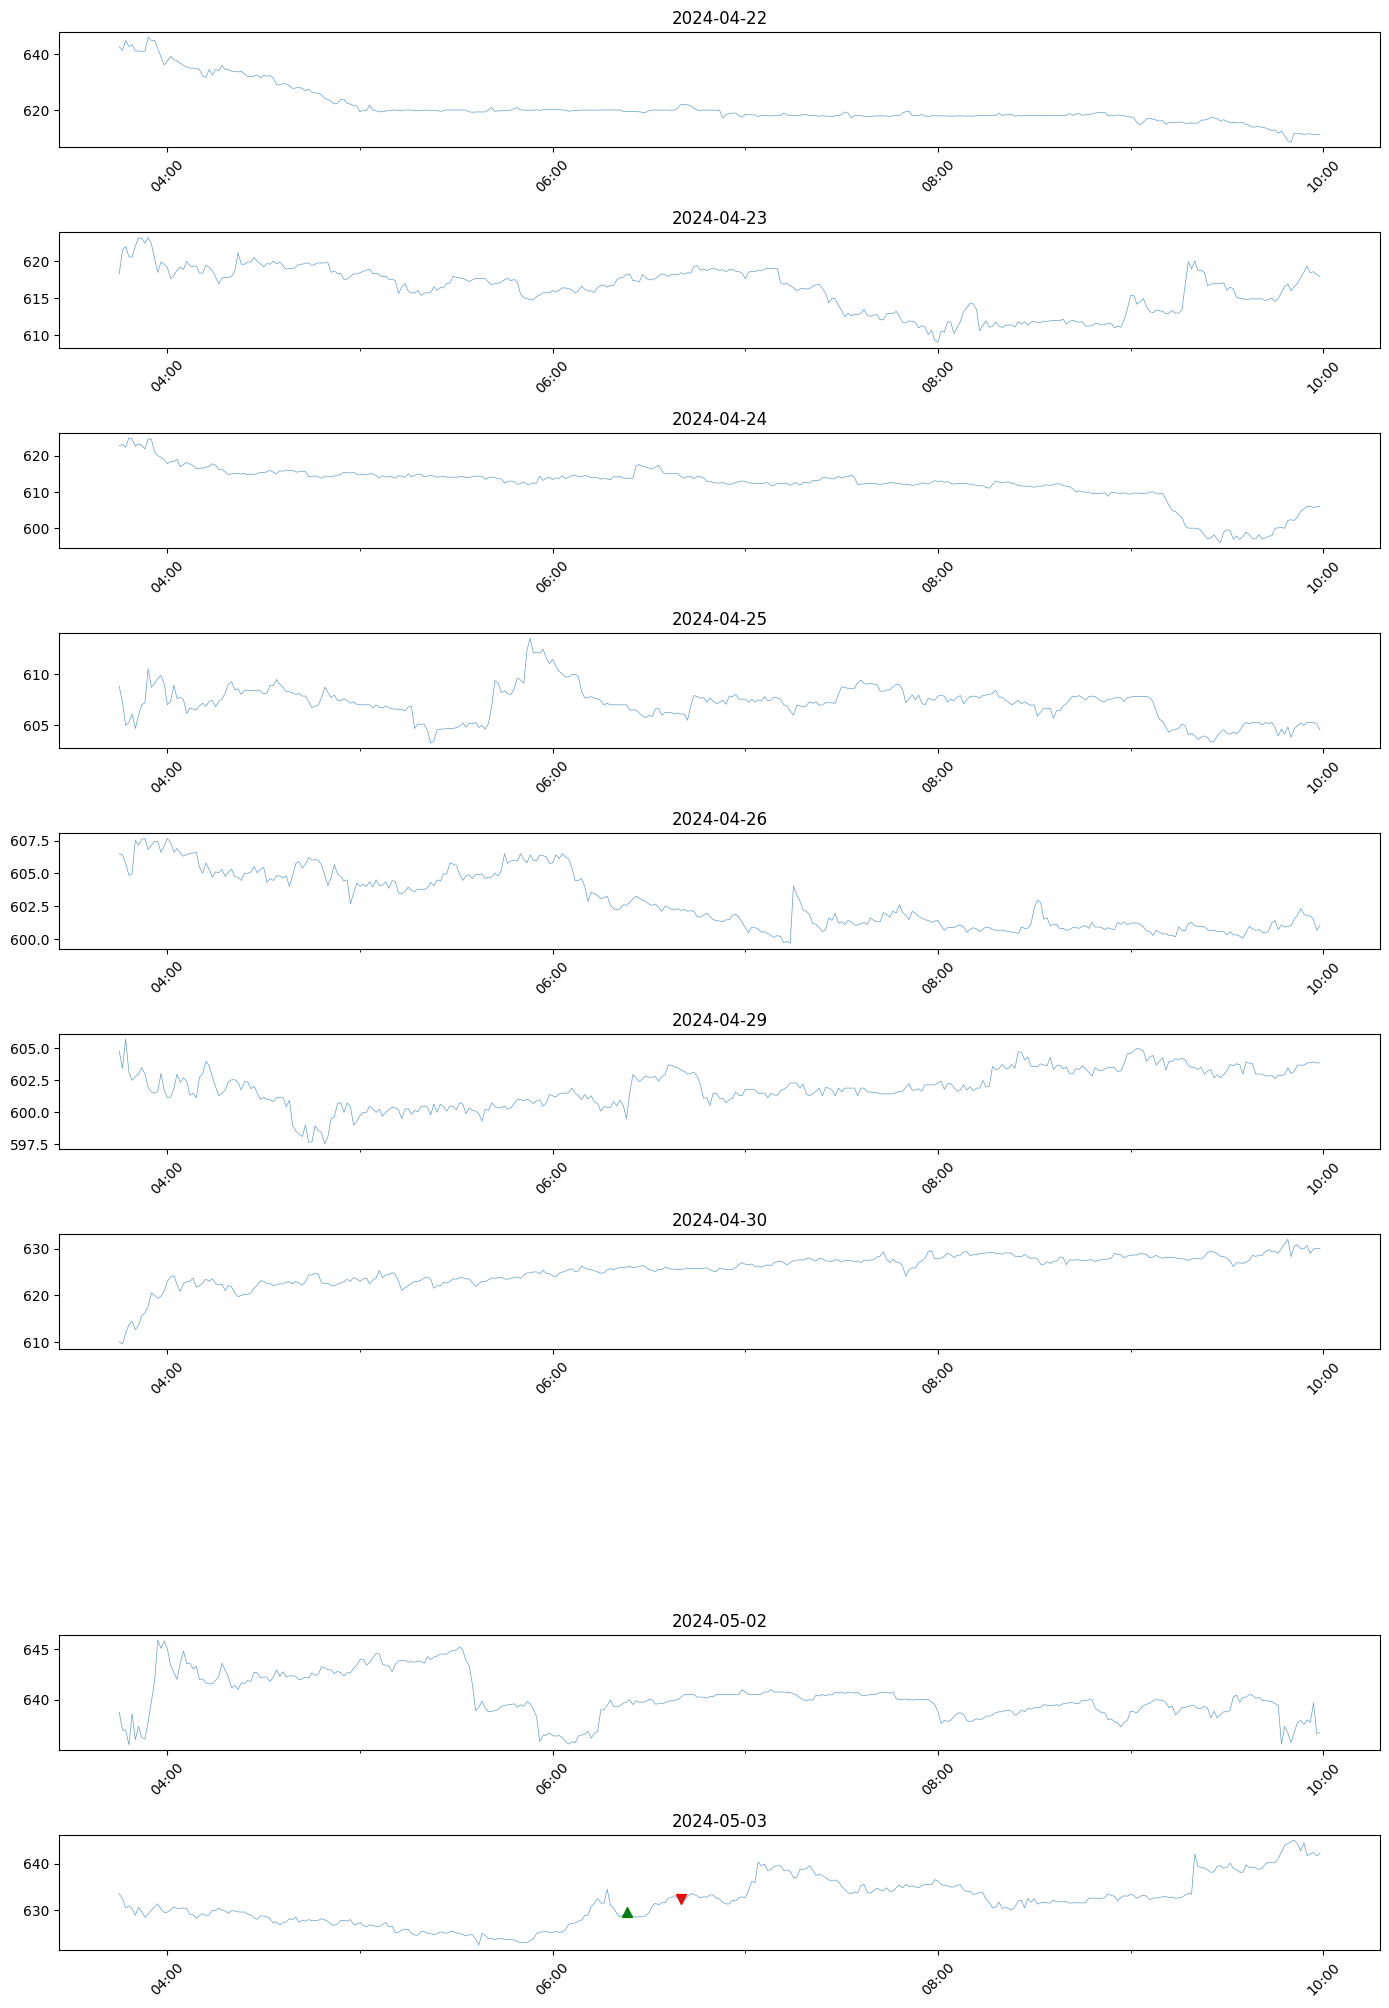

In [15]:
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
date_range = pd.date_range(start=start_date, end=end_date, freq='B')  # Business days in the range

# Determine the number of rows for subplots based on the number of days in the date range
num_days = len(date_range)
fig = plt.figure(figsize=(14, 2 * num_days))
gs = GridSpec(num_days, 1, fig)

for i, single_date in enumerate(date_range):
    daily_data = historical_data.loc[historical_data.index.date == single_date.date()]
    
    if daily_data.empty:
        continue
    
    ax = fig.add_subplot(gs[i, 0])
    ax.plot(daily_data.index, daily_data['Close'], label='Closing Price', linewidth=0.5, alpha=0.7)
    
    # Highlight buy/sell points for each day
    day_entries = trades_df[pd.to_datetime(trades_df['Entry Time']).dt.date == single_date.date()]
    day_exits = trades_df[pd.to_datetime(trades_df['Exit Time']).dt.date == single_date.date()]

    ax.scatter(pd.to_datetime(day_entries['Entry Time']), day_entries['Entry Price'], color='green', label='Buy', marker='^', s=50, alpha=1)
    ax.scatter(pd.to_datetime(day_exits['Exit Time']), day_exits['Exit Price'], color='red', label='Sell', marker='v', s=50, alpha=1)
    
    # Formatting the subplot
    ax.set_title(single_date.strftime('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Every 2 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    plt.xticks(rotation=45)
    if i == 0:  # Only add a legend to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()
